In [48]:
from __future__ import unicode_literals

import os
import cv2
import glob

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
from matplotlib.font_manager import FontProperties

In [49]:
lp_fn_list = glob.glob('/home/yoyo/Desktop/alpr-unconstrained/result/test-detector/*_*car_lp.png')

In [50]:
import random
lp_fn = random.choice(lp_fn_list)
lp_im = cv2.imread(lp_fn)

cv2.imshow(os.path.basename(lp_fn) + " " + str(lp_im.shape), lp_im)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [51]:
# # global thresholding
# ret1,th1 = cv2.threshold(lp_im,127,255,cv2.THRESH_BINARY)
# # Otsu's thresholding
# lp_im_grey = cv2.cvtColor(lp_im, cv2.COLOR_BGR2GRAY)
# ret2,th2 = cv2.threshold(lp_im_grey,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# # Otsu's thresholding after Gaussian filtering
# blur = cv2.GaussianBlur(lp_im_grey,(5,5),0)
# # ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# th3 = cv2.adaptiveThreshold(lp_im_grey,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
#             cv2.THRESH_BINARY,11,3)

# # plot all the images and their histograms
# images = [lp_im, 0, th1,
#           lp_im_grey, 0, th2,
#           blur, 0, th3]
# titles = ['Original Noisy Image','Histogram','Global Thresholding (v=%d)' % ret1,
#           'Grey Noisy Image','Histogram',"Otsu's Thresholding (v=%d)" % ret2,
#           'Gaussian filtered Image','Histogram',"Adaptive Thresholding"]
# plt.figure(figsize=(15,10))
# for i in xrange(3):
#     plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
#     plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
#     plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
#     plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
#     plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
#     plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
# plt.show()

## Character Segmentation
Using adaptive thresholding where the threshold value is a gaussian-weighted sum of the neighbourhood values

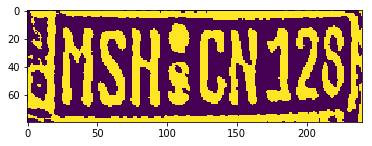

In [52]:
lp_im_grey = cv2.cvtColor(lp_im, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(lp_im_grey,(5,5),0)
th3 = cv2.adaptiveThreshold(lp_im_grey,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
                            cv2.THRESH_BINARY_INV,11,3)
plt.imshow(th3)

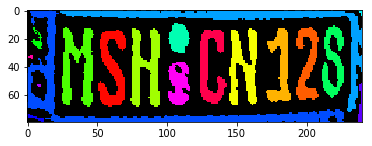

In [53]:
ret, labels = cv2.connectedComponents(th3)

def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    plt.imshow(labeled_img)
imshow_components(labels)

(0.6875, 16, 22, 242, 352, 0.7272727272727273)
(0.5408653846153846, 16, 52, 450, 832, 0.3076923076923077)
(0.3984375, 8, 16, 51, 128, 0.5)
(0.5423340961098398, 23, 57, 711, 1311, 0.40350877192982454)
(0.6003401360544217, 21, 56, 706, 1176, 0.375)
(0.5872727272727273, 20, 55, 646, 1100, 0.36363636363636365)
(0.4748427672955975, 18, 53, 453, 954, 0.33962264150943394)
(0.53125, 16, 52, 442, 832, 0.3076923076923077)
(0.5327272727272727, 20, 55, 586, 1100, 0.36363636363636365)
(0.5263157894736842, 19, 53, 530, 1007, 0.3584905660377358)
(0.6915322580645161, 16, 31, 343, 496, 0.5161290322580645)
(0.6190476190476191, 3, 28, 52, 84, 0.10714285714285714)


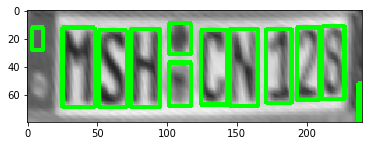

In [54]:
def findbox(bw):
    rows = np.any(bw, axis=1)
    cols = np.any(bw, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    x = cmin
    y = rmin
    w = cmax - cmin + 1
    h = rmax - rmin + 1
    return x, y, w, h
    

bbox = []
for i in range(1,ret):
    x, y, w, h = findbox(labels==i)
    a = (labels==i).sum()
    if a < 50 or a/float(w*h) < 0.2 or w > 50 or w/float(h) > 1:
        continue
    print(a/float(w*h), w, h, a, w*h, w/float(h))
    bbox.append((x,y,w,h))

lp_bbox = lp_im.copy()
for x, y, w, h in bbox:
    cv2.rectangle(lp_bbox,(x,y),(x+w,y+h),(0,255,0),2)
plt.imshow(lp_bbox)

In [55]:
from scipy.stats import tmean
arr = np.array([b[3] for b in bbox])
print '%f +/- %f' % (arr.mean(), arr.std())
h_char = tmean(arr, (arr.mean()-arr.std(), arr.mean()+arr.std()))
print h_char

44.166667 +/- 14.542085
51.55555555555556


In [56]:
arr

array([22, 52, 16, 57, 56, 55, 53, 52, 55, 53, 31, 28])

In [57]:
# kernel = np.ones((3,3),np.uint8)
# erosion = cv2.erode(th3,kernel,iterations = 1)
# plt.imshow(erosion,'gray')

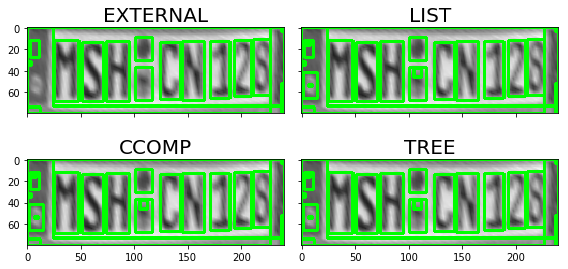

In [58]:
lp_bboxes = []
for val in [cv2.RETR_EXTERNAL, cv2.RETR_LIST, cv2.RETR_CCOMP, cv2.RETR_TREE]:
    contours, _ = cv2.findContours(th3, val, cv2.CHAIN_APPROX_SIMPLE)
    lp_bbox = lp_im.copy()
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
    #     if rect[2] < 100 or rect[3] < 100: continue
        #print cv2.contourArea(c)
        cv2.rectangle(lp_bbox,(x,y),(x+w,y+h),(0,255,0),2)
    lp_bboxes.append(lp_bbox)


# display results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)
ax = axes.ravel()
names = ["EXTERNAL", "LIST", "CCOMP", "TREE"]
for i in range(4):
    ax[i].imshow(lp_bboxes[i], cmap=plt.cm.gray)
    ax[i].set_title(names[i], fontsize=20)
fig.tight_layout()
plt.show()

10.5 72 0.145833333333
23.0 84 0.27380952381
316.5 496 0.63810483871
2.0 9 0.222222222222
441.0 1007 0.437934458788
499.0 1100 0.453636363636
380.0 954 0.398322851153
529.0 1100 0.480909090909
589.5 1176 0.501275510204
366.5 832 0.440504807692
588.0 1311 0.448512585812
31.0 128 0.2421875
363.0 832 0.436298076923
214.0 352 0.607954545455
2.0 12 0.166666666667
1146.0 15768 0.0726788432268
1568.5 18160 0.0863711453744


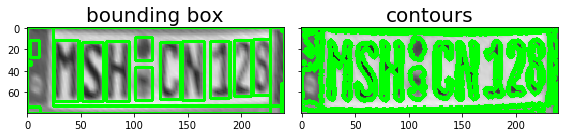

In [59]:
contours, _ = cv2.findContours(th3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
lp_char = lp_im.copy()
lp_bbox = lp_im.copy()
lp_contour = lp_im.copy()
ws = []
hs = []
for c in contours:
    x,y,w,h = cv2.boundingRect(c)
#     if cv2.contourArea(c) < 200 or cv2.contourArea(c)/(w*h) < 0.35:
#         continue
#     if rect[2] < 100 or rect[3] < 100: continue
    ws.append(w)
    hs.append(h)
    print cv2.contourArea(c), w*h, cv2.contourArea(c)/ (w*h)
    cv2.rectangle(lp_bbox,(x,y),(x+w,y+h),(0,255,0),2)
cv2.drawContours(lp_contour, contours, -1, (0,255,0), 3)



# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(lp_bbox, cmap=plt.cm.gray)
# ax[0].axis('off')
ax[0].set_title('bounding box', fontsize=20)

ax[1].imshow(lp_contour, cmap=plt.cm.gray)
# ax[1].axis('off')
ax[1].set_title('contours', fontsize=20)

fig.tight_layout()
plt.show()

In [60]:
import numpy as np
from scipy import stats
m = stats.mode(np.array(hs))
print(m)

ModeResult(mode=array([52]), count=array([2]))


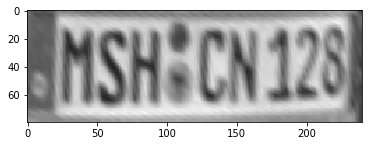

In [61]:
plt.imshow(lp_im)

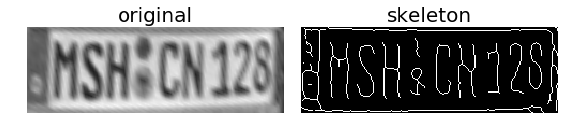

In [62]:
from skimage.morphology import skeletonize
from skimage.util import invert

# perform skeletonization
skeleton = skeletonize(th3>0)

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(lp_im, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
plt.show()

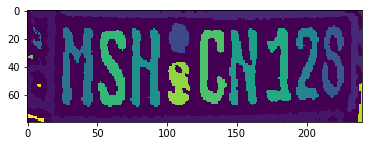

In [63]:
from skimage import measure
all_labels = measure.label(th3>0)
blobs_labels = measure.label(th3>0, neighbors=8, background=0)
plt.imshow(blobs_labels)

ก ข ฃ ค ฅ ฆ ง จ ฉ ช ซ ฌ ญ ฎ ฏ ฐ ฑ ฒ ณ ด ต ถ ท ธ น บ ป ผ ฝ พ ฟ ภ ม ย ร ล ว ศ ษ ส ห ฬ อ ฮ A B C D E F G H I J K L M N O P Q R S T U V W X Y Z 0 1 2 3 4 5 6 7 8 9

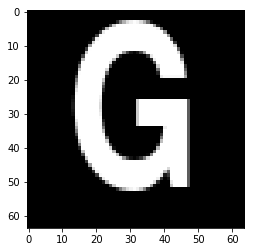

In [64]:
from PIL import Image, ImageDraw, ImageFont

if not os.path.exists('lp_char'):
    os.makedirs('lp_char')
x = 0

c = range(0x0E01, 0x0E2F) + range(65, 91) + range(48, 58)
c.remove(0x0E24)
c.remove(0x0E26)
for i in c:
    print unichr(i),
    
    img = Image.new('RGB', (64, 64))
    draw = ImageDraw.Draw(img)
    # font = ImageFont.truetype(<font-file>, <font-size>)
    font = ImageFont.truetype("Sarun's ThangLuang.ttf", 66)
    # draw.text((x, y),"Sample Text",(r,g,b))
    w, h = draw.textsize(unichr(i), font=font)
    draw.text(((64-w)/2,-46),unichr(i),(255,255,255),font=font)
    img.save('lp_char/%02d.png' % x)
    x += 1
plt.imshow(cv2.imread('lp_char/50.png'))

In [65]:
import scipy
from scipy.ndimage.morphology import distance_transform_edt
char_fn_list = sorted(glob.glob('lp_char/*.png'))
chdist = []
for char_fn in char_fn_list:
    im = cv2.imread(char_fn)
    im_grey = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    x, y, w, h = findbox(im_grey > 100)
    skeleton = skeletonize(im_grey[y:y+h, x:x+w] > 100)
    dist = scipy.ndimage.morphology.distance_transform_edt(~skeleton)
    # dist = distance_transform_edt(im_grey[y:y+h, x:x+w] == 0)
    chdist.append(dist)

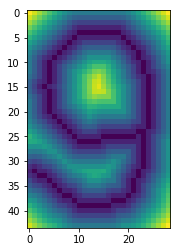

In [66]:
plt.imshow(dist)

In [67]:
im = cv2.imread('lp_char/50.png')
im_grey = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

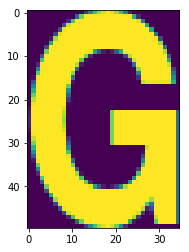

In [68]:
x, y, w, h = findbox(im_grey>0)
plt.imshow(im_grey[y:y+h, x:x+w])

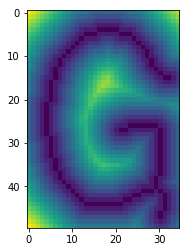

In [69]:
import scipy
from skimage.morphology import skeletonize
from skimage.util import invert

# perform skeletonization
skeleton = skeletonize(im_grey[y:y+h, x:x+w] > 100)

dist = scipy.ndimage.morphology.distance_transform_edt(~skeleton)
plt.imshow(dist)

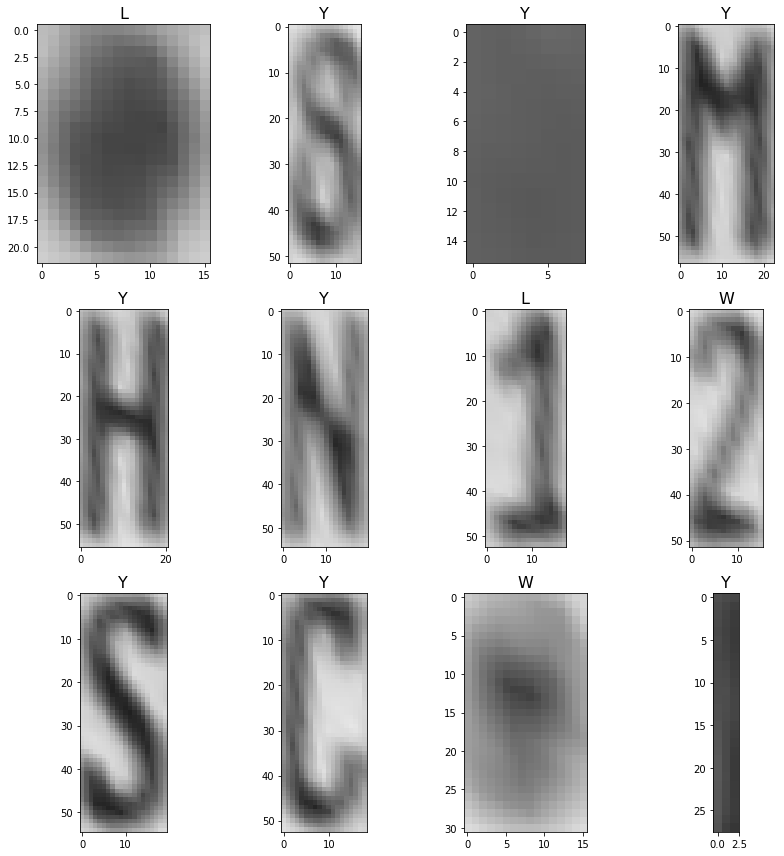

In [70]:
nrow = np.ceil(len(bbox) / 4.0).astype('int32')


# display results
fig, axes = plt.subplots(nrows=nrow, ncols=4, figsize=(12, nrow*4))
ax = axes.ravel()

for i, (x,y,w,h) in enumerate(bbox):
    lp_char = lp_im[y:y+h, x:x+w]
    lp_char_mask = th3[y:y+h, x:x+w]
    ax[i].imshow(lp_char, cmap=plt.cm.gray)
    
    sc = np.zeros((len(chdist)))
    for j, dist in enumerate(chdist):
        lp_char_resize = cv2.resize(lp_char_mask, dist.shape[::-1], interpolation = cv2.INTER_NEAREST)
        sc[j] = (lp_char_resize * dist).sum()
    
    idx = np.where(sc == sc.max())[0][0]
    ax[i].set_title(unichr(c[idx]), fontsize=16)
fig.tight_layout()
plt.show()

In [71]:
unichr(c[72])

u'2'

In [72]:
char_fn_list = sorted(glob.glob('lp_char/*.png'))
chlist = []
for char_fn in char_fn_list:
    im = cv2.imread(char_fn)
    im_grey = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    x, y, w, h = findbox(im_grey > 100)
    
    scale = h_char/h
    width = int(w * scale)
    height = int(h * scale)
    dim = (width, height)
    resized = cv2.resize(255 - im_grey[y:y+h, x:x+w], dim, interpolation = cv2.INTER_AREA)

    chlist.append(resized)

In [73]:
im.shape[1]

64

In [74]:
resized.shape

(51, 33)

In [75]:
h_char/h

1.1717171717171717

In [76]:
h_char, h

(51.55555555555556, 44)

In [77]:
im_grey.shape[0] * scale

74.98989898989899

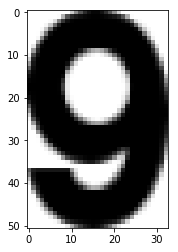

In [78]:
plt.imshow(chlist[79], cmap='gray')

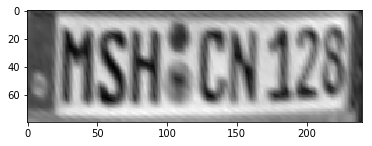

In [79]:
plt.imshow(lp_im_grey, cmap='gray')

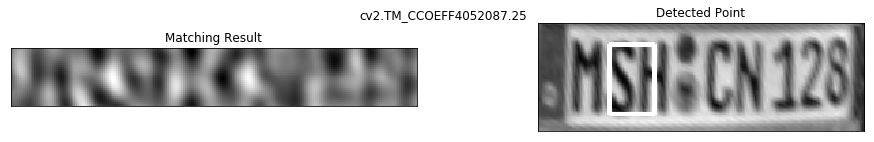

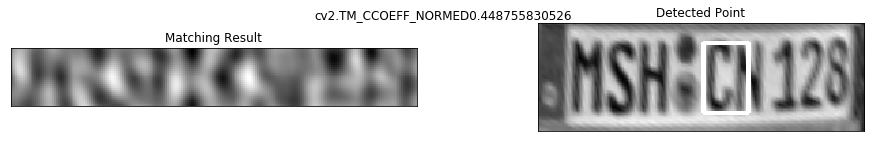

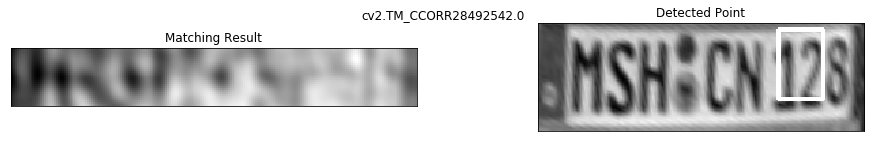

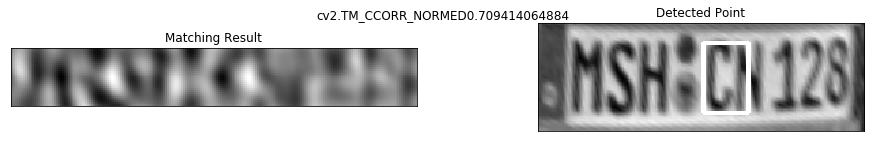

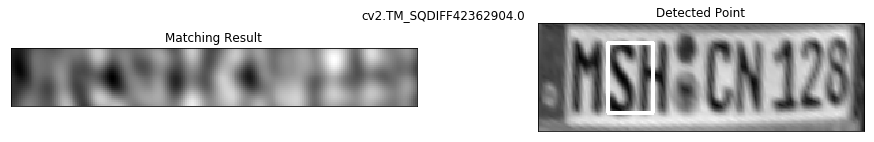

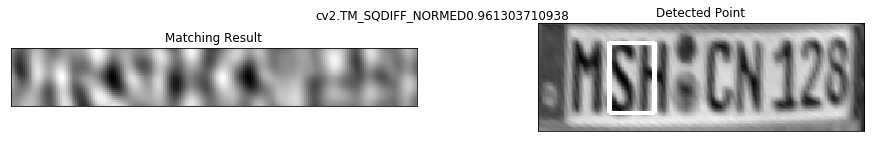

In [80]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img2 = lp_im_grey.copy()
template = chlist[79]
w, h = template.shape[::-1]

# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
for meth in methods:
    img = img2.copy()
    method = eval(meth)

    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(img,top_left, bottom_right, 255, 2)

    plt.figure(figsize=(16,2))
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth + str(max_val))

    plt.show()

In [81]:
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
max_val, max_loc

(0.9613037109375, (25, 15))

In [82]:
from skimage.feature import peak_local_max

def tup_dist(a,b):
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

img2 = lp_im_grey.copy()

sc = np.zeros((len(chlist)))
cand = [[] for i in range(len(bbox))]
for i, template in enumerate(chlist):
    img = img2.copy()
    res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF)
#     res = res.max() - res
    coordinates = peak_local_max(res, min_distance=5, threshold_rel=0.95, num_peaks=5)
#     print(i,coordinates)
    for y, x in coordinates:
        # min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        for k, bb in enumerate(bbox):
            # dis = tup_dist(bb[:2], max_loc)
            dis = tup_dist(bb[:2], (x,y))
            if dis < 7:
                #cand[k].append((max_val, max_loc, unichr(c[i])))
                cand[k].append((res[y,x], (x,y), unichr(c[i]), dis))
#                 print(i)
        
    #print res.shape, max_val
#     sc[i] = max_val
# plt.plot(sc)
    


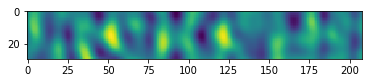

In [83]:
plt.imshow(res)

In [84]:
template.shape

(51, 33)

In [85]:
cand = [sorted(cnd, key=lambda x: x[0], reverse=True)[:5] for cnd in cand]
cand

[[(5193434.0, (98, 11), u'\u0e21', 3.605551275463989),
  (5135633.5, (99, 14), u'\u0e19', 5.385164807134504),
  (4326822.5, (98, 11), u'\u0e06', 3.605551275463989)],
 [],
 [],
 [(3877865.5, (22, 14), u'\u0e0a', 3.605551275463989)],
 [],
 [],
 [(4363977.0, (174, 12), u'2', 3.1622776601683795),
  (4271396.0, (168, 14), u'1', 3.1622776601683795)],
 [],
 [(4127911.0, (49, 18), u'S', 4.47213595499958),
  (4052087.2, (52, 16), u'9', 2.23606797749979),
  (2917592.0, (48, 14), u'\u0e10', 3.0)],
 [(6394139.5, (120, 15), u'O', 4.123105625617661),
  (6166727.0, (120, 14), u'0', 4.0),
  (6134172.0, (120, 19), u'Q', 6.4031242374328485),
  (6068372.0, (123, 14), u'D', 1.0),
  (5679448.5, (118, 13), u'\u0e20', 6.082762530298219)],
 [],
 []]

ม
ช
2
S
O


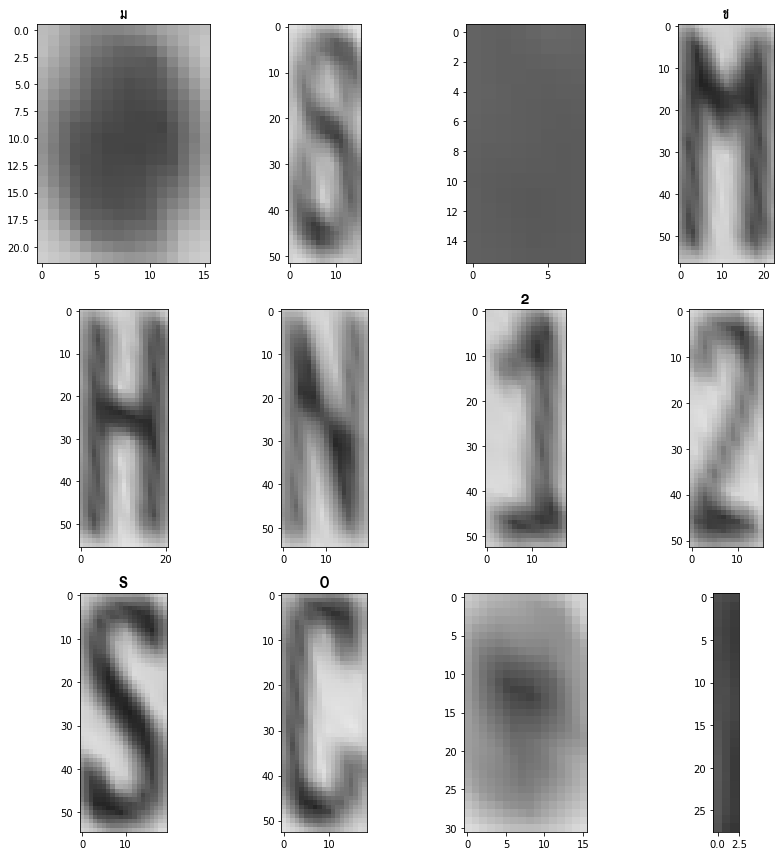

In [86]:
nrow = np.ceil(len(bbox) / 4.0).astype('int32')
# display results
fig, axes = plt.subplots(nrows=nrow, ncols=4, figsize=(12, nrow*4))
ax = axes.ravel()

for i, ((x,y,w,h), cnd) in enumerate(zip(bbox,cand)):
    lp_char = lp_im[y:y+h, x:x+w]
    lp_char_mask = th3[y:y+h, x:x+w]
    ax[i].imshow(lp_char, cmap=plt.cm.gray)
    
    sc = np.zeros((len(chdist)))
    for j, dist in enumerate(chdist):
        lp_char_resize = cv2.resize(lp_char_mask, dist.shape[::-1], interpolation = cv2.INTER_NEAREST)
        sc[j] = (lp_char_resize * dist).sum()
    
    idx = np.where(sc == sc.max())[0][0]
    if cnd != []:
        print cnd[0][2]
        ax[i].set_title(cnd[0][2], fontsize=16, fontproperties = FontProperties("Sarun's ThangLuang"))
fig.tight_layout()
plt.show()